## Задача:

На сайте запущен А/В тест с целью увеличить общий доход. В приложенном Excel-файле (AB-test-raw-data.xlsx) содержатся сырые данные по результатам эксперимента (USER_ID), тип выборки (VARIANT_NAME) и доход, принесенный пользователем (REVENUE). \
Требуется провести анализ результатов эксперимента и на его основе предоставить рекомендации менеджеру.

> __A/B-тест__ — это инструмент, который позволяет делать надёжные выводы о влиянии изменения на продукт, за счёт использования статистических методов и параллельного сбора данных для сравниваемых групп.

В нашем случае сам эксперимент уже проведен. Задача заключается в том, чтобы интерпретировать результаты теста и сделать выводы о возможности внедрения изменения в работу нашего сервиса.

## Получение данных

In [1]:
# Импортируем некоторые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm

In [2]:
# Считаем предоставленные в формате Excel данные
data = pd.read_excel('/Users/ilnur/Downloads/AB-test-raw-data.xlsx') # <-- следует указать путь к файлу

# Окинем взглядом наши данные
data.info()
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


/Users/ilnur/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
...,...,...,...
9995,1981,control,0.0
9996,502,variant,0.0
9997,9214,variant,0.0
9998,7741,control,0.0


Также стоит отметить, что данные не нуждаются в преобразованиях или изменении формата. Мы можем начать анализировать данные в их текущем виде.

---
## Первичная оценка данных

In [3]:
# Для начала выделим контрольную и тестовую группы:
control_group = data[data['VARIANT_NAME'] == 'control']
variant_group = data[data['VARIANT_NAME'] == 'variant']


# Посчитаем количество сессий в обеих группах
print('Количество сессий в контрольной группе: {}\n'
      'Количество сессий в тестовой группе: {}'
.format(len(control_group),
        len(variant_group)))

Количество сессий в контрольной группе: 4984
Количество сессий в тестовой группе: 5016


VARIANT_NAME
control    643.00
variant    351.47
Name: REVENUE, dtype: float64


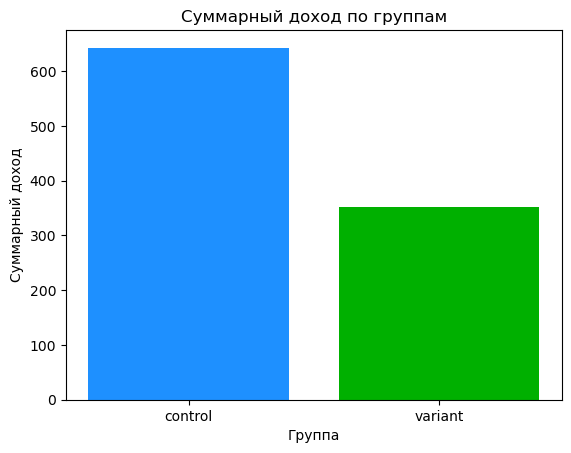

In [4]:
# Также не помешало бы узнать, как распределяется суммарный доход по группам
total_revenue = data.groupby('VARIANT_NAME')['REVENUE'].sum()
print(total_revenue)


# Добавим визуализацию
variant_revenue = data.groupby('VARIANT_NAME')['REVENUE'].sum()
plt.bar(variant_revenue.index, variant_revenue.values, color=['#1E90FF', '#00B000'])
plt.xlabel('Группа')
plt.ylabel('Суммарный доход')
plt.title('Суммарный доход по группам')
plt.show()

Неожиданно, суммарный доход в конторльной группе на порядок превышает доход в тестовой. В случае, если в данных нет ошибок, это могло бы означать, что эксперимент катастрофически сократил нашу выручку и раскатывать фичу однозначно не стоит. Однако не станем принимать поспешных решений и продолжим анализ.

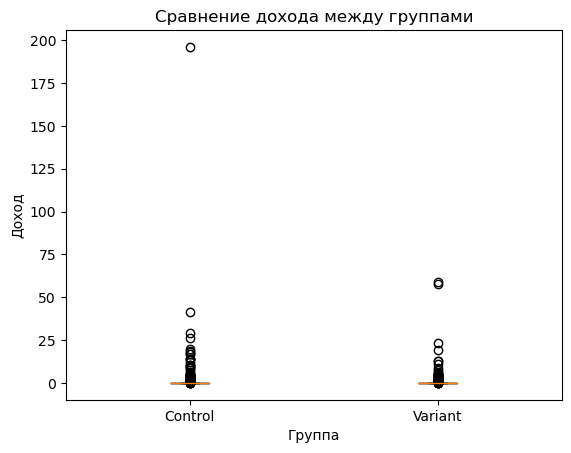

In [5]:
# Посмотрим на распределение величины выручки в разрезе групп
control_data = data[data['VARIANT_NAME'] == 'control']['REVENUE']
variant_data = data[data['VARIANT_NAME'] == 'variant']['REVENUE']


plt.boxplot([control_data, variant_data], labels=['Control', 'Variant'])
plt.ylabel('Доход')
plt.xlabel('Группа')
plt.title('Сравнение дохода между группами')
plt.show()

Оказалось, что в наших данных возник выброс: один из клиентов принес за сессию сразу около 200 единиц выручки, что значительно отличается от остальных нормальных значений метрики. \
Исключим экстримальное значение из данных, чтобы оно не исказило значение статистик. 
Исключение выброса позволяет убедиться, что тесты гипотез будут основаны на более типичных значениях.
## Работа с выбросами

In [6]:
excluded_value = max(control_data)
control_data = control_data[control_data != excluded_value]
data = data[data['REVENUE'] != excluded_value]

control_group = data[data['VARIANT_NAME'] == 'control']
variant_group = data[data['VARIANT_NAME'] == 'variant']

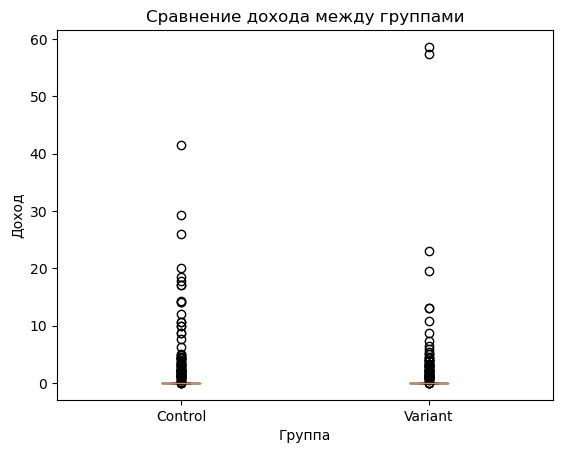

In [7]:
# Посмотрим на распределение после исключения выброса
plt.boxplot([control_data, variant_data], labels=['Control', 'Variant'])
plt.ylabel('Доход')
plt.xlabel('Группа')
plt.title('Сравнение дохода между группами')
plt.show()

Ситуация немного улучшилась. \
Однако теперь мы можем заметить два аномальных значения в тестовой группе. Так как они значительно выходят за пределы нормальных значений, то будет разумным исключить и их из анализа.

In [8]:
for i in range(2):
    excluded_value = max(variant_data)
    variant_data = variant_data[variant_data != excluded_value]
    data = data[data['REVENUE'] != excluded_value]
control_group = data[data['VARIANT_NAME'] == 'control']
variant_group = data[data['VARIANT_NAME'] == 'variant']

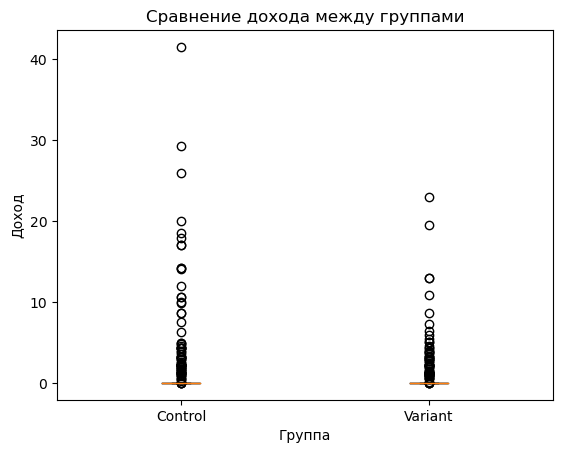

In [9]:
# Посмотрим на распределение после исключения всех выбросов
plt.boxplot([control_data, variant_data], labels=['Control', 'Variant'])
plt.ylabel('Доход')
plt.xlabel('Группа')
plt.title('Сравнение дохода между группами')
plt.show()

Отлично, с такими данными уже можно работать!

In [10]:
# Рассчитаем средние значения
control_mean = control_group['REVENUE'].mean()
variant_mean = variant_group['REVENUE'].mean()
print(f'Средний доход в контрольной группе: {control_mean}')
print(f'Средний доход в тестовой группе: {variant_mean}')

Средний доход в контрольной группе: 0.08970299016656635
Средний доход в тестовой группе: 0.04694455524531313


Из полученных данных видно, __что сессии, на которых тестировались изменения, в среднем приносят компании меньше дохода, чем сессии, в которых таких изменений не было__. 

## Выбор подходящего теста

Следующим этапом для нас становится проведение статистического теста, чтобы определить, действительно ли эти различия в доходах являются статистически значимыми.
При выборе теста будем опираться на специфику анализируемых данных:
1. __Тип метрики.__ Выручка — это количественная метрика, значит, выбор стоит между t-тестом и бакетным тестом.
2. __Нормальность распределения.__ Распределение выручки за сессию, как и других денежных метрик, часто скошено, что понижает мощность t-теста (мы будем реже отвергать нулевую гипотезу, когда она на самом деле должна быть отвергнута). Это подталкивает нас к выбору бакетного теста.
3. __Количество наблюдений.__ В нашем случае размер каждой из групп примерно равен 5000. Этого количества наблюдений достаточно для применения бакетного теста.

Таким образом, наиболее подходящим вариантом для наших данных будет являться проведение __бакетного теста__. Разобьем данные в каждой выборке на __100 бакетов__ и вычислим среднее значение по каждому бакету. К полученным данным применяим __двухвыборочный t-тест__. 

## Трансформация данных

In [11]:
# Распределим сессии по бакетам с сохранением равного количества в каждом
bucket_number = 100
control_group['BUCKET'] = np.tile(np.arange(1, bucket_number + 1), int(np.ceil(len(control_group) / bucket_number)))[:len(control_group)]
variant_group['BUCKET'] = np.tile(np.arange(1, bucket_number + 1), int(np.ceil(len(variant_group) / bucket_number)))[:len(variant_group)]

# Перетасуем бакеты для случайности и объединим данные в одну таблицу
control_group['BUCKET'] = np.random.permutation(control_group['BUCKET'])
variant_group['BUCKET'] = np.random.permutation(variant_group['BUCKET'])
bucket_data = pd.concat([control_group, variant_group])
bucket_data

/var/folders/84/r71blcnd0ydfkn2236j_0jk00000gn/T/ipykernel_8397/1002983396.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  control_group['BUCKET'] = np.tile(np.arange(1, bucket_number + 1), int(np.ceil(len(control_group) / bucket_number)))[:len(control_group)]
/var/folders/84/r71blcnd0ydfkn2236j_0jk00000gn/T/ipykernel_8397/1002983396.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variant_group['BUCKET'] = np.tile(np.arange(1, bucket_number + 1), int(np.ceil(len(variant_group) / bucket_number)))[:le

,USER_ID,VARIANT_NAME,REVENUE,BUCKET
1,2423,control,0.0,58
2,9411,control,0.0,54
3,7311,control,0.0,69
6,2849,control,0.0,73
7,9168,control,0.0,51
...,...,...,...,...
9991,8864,variant,0.0,95
9992,9303,variant,0.0,77
9993,2400,variant,0.0,63
9996,502,variant,0.0,85


In [12]:
# Расчитаем среднюю выручу по бакетам в каждой группе
bucket_means = bucket_data.groupby(['VARIANT_NAME', 'BUCKET'])['REVENUE'].mean().reset_index()
bucket_means = bucket_means.rename(columns={'REVENUE': 'AVERAGE_REVENUE'})
bucket_means

,VARIANT_NAME,BUCKET,AVERAGE_REVENUE
0,control,1,0.0000
1,control,2,0.0716
2,control,3,0.0990
3,control,4,0.2814
4,control,5,0.0000
...,...,...,...
195,variant,96,0.0214
196,variant,97,0.0000
197,variant,98,0.0250
198,variant,99,0.0200


Распределение новых значений уже подчиняется центральной предельной теореме, а значит, стремится к нормальному.

## Реализация статистического теста
Наконец, можно проводить статистический тест! Сначала выдвенем гипотезу: 

- $H_0: \mu_1 - \mu_2 = 0$
- $H_1: \mu_1 - \mu_2 \neq 0$ 
- Уровень значимости (он же допустимая вероятность ошибки первого рода): $\alpha = 0.05$

In [13]:
# Проведем расчет средних значений и стандартных отклонений в группах по бакетам
control_mean = np.mean(bucket_means[bucket_means['VARIANT_NAME'] == 'control']['AVERAGE_REVENUE'])
control_std = np.std(bucket_means[bucket_means['VARIANT_NAME'] == 'control']['AVERAGE_REVENUE'])
variant_mean = np.mean(bucket_means[bucket_means['VARIANT_NAME'] == 'variant']['AVERAGE_REVENUE'])
variant_std = np.std(bucket_means[bucket_means['VARIANT_NAME'] == 'variant']['AVERAGE_REVENUE'])

print(f'Среднее значение в контрольной группе: {control_mean}')
print(f'Стандартное отклонение в контрольной группе: {control_std}')
print(f'Среднее значение в тестовой группе: {variant_mean}')
print(f'Стандартное отклонение в тестовой группе: {variant_std}')

Среднее значение в контрольной группе: 0.08978155102040813
Стандартное отклонение в контрольной группе: 0.15388409099671158
Среднее значение в тестовой группе: 0.04698207843137255
Стандартное отклонение в тестовой группе: 0.10143029412367204


In [14]:
# Вычислим оценку стандартной ошибки среднего
ese = np.sqrt((control_std**2 / bucket_number) + (variant_std**2 / bucket_number))

# Посчитаем t-статистику
t_statistic = (control_mean - variant_mean) / ese

# Далее рассчитаем степени свободы по упрощенной формуле
df = ((bucket_number - 1) * (control_std**2 + variant_std**2)**2) / (control_std**4 + variant_std**4)

# И наконец, найдем p-value
p_value = 2 * (1 - sp.stats.t.cdf(abs(t_statistic), df=df))
print(f'P-значение составляет: {p_value}')

P-значение составляет: 0.02139778030670514


## Интерпритация результатов
_P-значение_ __оказалось ниже__ предварительно выбранного уровня значимости. Это говорит о том, что у нас есть достаточно оснований для того, чтобы __отклонить нулевую гипотезу__. Таким образом, статистический анализ подтверждает __наличие статистически значимых изменений__. Это не случайность, а скорее отражение реальных различий между группами. Красный тест дает нам явные показания о том, что мы наблюдаем статистически значимое __снижение в метрике__. \
Исходя из этого, развертывание тестируемой функции __явно стоит откложить__, так как изменения довольно вероятно приведут к нежелательному снижению выручки.

Рекомендуется провести более подробный анализ результатов теста. Полезно будет изучить конкретные аспекты и факторы, которые могли повлиять на данное снижение метрики. Это позволит более точно понять, какие именно особенности изменений привели к негативным результатам.